# Map projections 

### References

- Snyder, Map Projections Manual 

## __*Polar Stereographic*__

### Forward Formulas 

The general forward formulas for the oblique aspect are as follows

\begin{align}
x &= A \cos\chi\sin\left(\lambda - \lambda_0\right) \\
y &= A \left[ \cos\chi_1 \sin\chi - \sin\chi_1 \cos\chi \cos(\lambda - \lambda_0) \right] \\
k &= A \cos(\chi_1) / ( a m )
\end{align}

where 

\begin{align}
A &= 2 a k_0 m_1 / \left\{\cos\chi_1 [1 + \sin\chi_1\sin\chi + \cos\chi_1\cos\chi\cos\left( \lambda - \lambda_0 \right) \right\} \\
x &= 2 \arctan \left\{\tan\left(\pi/4 + \phi/2\right)\left[\left(1 - e\sin\phi\right) / \left(1 + e\sin\phi\right)\right]^{e/2}\right\} - \pi / 2 \\
  &= 2 \arctan\left[\left(\frac{1 + \sin\phi}{1 - \sin\phi}\right) \left(\frac{1 - e\sin\phi}{1 + e\sin\phi}\right)^e \right]^{1/2} - \pi / 2 \\
m &= \cos\phi / \left(1 - e^2\sin^2\phi\right)^{1/2}
\end{align}

and $\chi_1$ and $m_1$ are $\chi$ and $m$, respectively, calculated using $\phi_1$. the central latitude, in place of $\phi$, while $k_0$ is the scale factor at the center (normally $1.0$).

__Equatorial aspect__ $\left(\phi_1 = 0 \rightarrow \chi_1 = 0 \right)$: 

\begin{align}
x &= A \cos\chi\sin\left(\lambda - \lambda_0\right) \\
y &= A \sin\chi \\
A &= 2 a k_0 / \left[ 1 + \cos\chi \cos\left( \lambda - \lambda_0 \right) \right]
\end{align}

__North polar aspect__ $\left(\phi_1 = 90 \rightarrow \chi_1 = 90 \right)$: 

\begin{align}
x &=  \rho \sin\left(\lambda - \lambda_0\right) \\
y &= -\rho \cos\left(\lambda - \lambda_0\right) \\
k &=  \rho / ( a m )
\end{align}

where 

\begin{align}
\rho &= 2 a k_0 t / \left[ \left(1 + e\right)^{\left(1 + e\right)} \left(1 - e\right)^{\left(1 - e\right)} \right]^{1/2} \\
t    &= \tan\left(\pi/4 - \phi/2\right) \left[\left(1 - e\sin\phi\right) / \left(1 + e\sin\phi\right)\right]^{e/2} \\
     &= \left[\left(\frac{1 - \sin\phi}{1 + \sin\phi}\right) \left(\frac{1 + e\sin\phi}{1 - e\sin\phi}\right)^e \right]^{1/2} \\
\end{align}

For the __south polar aspect__, the equations for the north polar aspect may be used, but the *signs* of $x$, $y$, $\phi_c$, $\phi$, $\lambda$, and $\lambda_0$ must be *reversed* to be used in the equations.

### Reverse Formulas 

__Oblique (and equatorial) aspects__: 

\begin{align}
\phi &= 2\arctan\left\{ \tan\left(\pi/4 + \chi/2\right) \left[\left(1 + e\sin\phi\right) / \left(1 - e\sin\phi\right)\right]^{e/2}\right\} - \pi/2 \\
\lambda &= \lambda_0 +  \arctan\left[ \frac{x\sin{c_e}}{\rho \cos\chi_1\cos{c_e} - y \sin\chi_1\sin{c_e}} \right] 
\end{align}

where 

\begin{align}
\xi &= \arcsin\left[ \cos{c_e}\sin\chi_1 + \left( y \sin{c_e}\cos\chi_1/\rho\right) \right]
\end{align}

but if $\phi_0 = 0$, $\chi = \chi_1$, $\lambda = \lambda_0$: 

\begin{align}
\rho &= \left(x^2 + y^2\right)^{1/2} \\ 
c_e  &= 2\arctan\left[\rho \cos\chi_1 / (2ak_0m_1) \right] 
\end{align}

In [1]:
import sys 
import pathlib as pb 
import json 

import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import pyproj as pj 

# Getting custom modules
# Add the root of your project to PYTHONPATH
rootpath = pb.Path('.').resolve().parents[1]
syspath = str(rootpath.joinpath("src", "cimr_grasp"))
sys.path.append(syspath) 
syspath = str(rootpath.joinpath("src"))
sys.path.append(syspath)
print(syspath)
import grasp_io as gio
from config_file import ConfigFile
from grid_generator import GridGenerator, GRIDS
from data_ingestion import DataIngestion
from regridder_v2 import ReGridder

# NSIDC guide to this projection provides custom grid values: 
# https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection

# Northern Hemisphere Grid Coordinates 
# upper left corner:   X = -3850, Y = 5850
# top mid point:       X = 0, Y = 5850
# upper right corner:  X = 3750, Y = 5850 
# right side midpoint: X = 3750, Y = 0
# lower right corner:  X = 3750, Y = -5350
# bottom midpoint:     X = 0, Y = -5350 
# lower left corner:   X = -3850, Y = -5350 
# left side midpoint:  X = -3850, Y = 0 

# The grid size cell dimensions in km
VALID_GRID_SIZES = (6.25, 12.5, 25)

# Valid hemisphere names.
NORTH = 'north'
SOUTH = 'south'
VALID_HEMISPHERES = (NORTH, SOUTH)

# Earth-parameter defualts
TRUE_SCALE_LATITUDE = 70
EARTH_RADIUS_KM = 6378.273
EARTH_ECCENTRICITY = 0.081816153

grid_size = 6.25
print(-3850 + grid_size / 2)

def _grid_params(grid_size, hemisphere):
    if hemisphere == NORTH:
        delta = 45
        imax = 1216
        jmax = 1792
        xmin = -3850 + grid_size / 2
        ymin = -5350 + grid_size / 2
    else:
        delta = 0
        imax = 1264
        jmax = 1328
        xmin = -3950 + grid_size / 2
        ymin = -3950 + grid_size / 2

    if grid_size == 12.5:
        imax = imax // 2
        jmax = jmax // 2
    elif grid_size == 25:
        imax = imax // 4
        jmax = jmax // 4

    return delta, imax, jmax, xmin, ymin

# grid_size = 6.25
# print(-3850 + grid_size / 2) # <= xmin 
# -3846.875

# in km 
GRIDS = {
         'NSIDC_N6.25km': {'epsg': 3413, 'x_min': -3850000, 'y_max': 5850000, 
                           'res': 6250, 'n_cols': 1216, 'n_rows': 1792},
         'NSIDC_N12.5km': {'epsg': 3413, 'x_min': -3850000, 'y_max': 5850000,
                           'res': 12500, 'n_cols': 608, 'n_rows': 896},
         'NSIDC_N25km':   {'epsg': 3413, 'x_min': -3850000, 'y_max': 5850000,
                           'res': 25000, 'n_cols': 304, 'n_rows': 448},
         'NSIDC_S6.25km': {'epsg': 3976, 'x_min': -3950000, 'y_max': 4350000,
                           'res': 6250, 'n_cols': 1264, 'n_rows': 1328},
         'NSIDC_S12.5km': {'epsg': 3976, 'x_min': -3950000, 'y_max': 4350000,
                           'res': 12500, 'n_cols': 632, 'n_rows': 664},
         'NSIDC_S25km':   {'epsg': 3976, 'x_min': -3950000, 'y_max': 4350000,
                           'res': 25000, 'n_cols': 316, 'n_rows': 332}
         }
# North: 
# +proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs
# 
# South: 
# +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs
PROJECTIONS = {
               'UPS_N': "+proj=stere +lat_0=90 +lon_0=-45 +lat_ts=70 +k=1 +x_0=0 +y_0=0 "
                    "+datum=WGS84 +ellps=WGS84 +units=m +no_defs",
               'UPS_S': "+proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y_0=0 "
                    "+datum=WGS84 +ellps=WGS84 +units=m +no_defs"
              }

# lonlat_to_xy is what I need to write (i.e., to overwrite the onex defined in the projection class)


if __name__ == '__main__': 

    # Initiate config object and validate parameters.
    configpath = rootpath.joinpath('config-maks.xml')
    config = ConfigFile(configpath)#os.path.join(os.getcwd(), '..', 'config.xml'))
    # Now you can play around with some SMAP data. The l1b data is given in lon, lat (epsg:4326)
    # and you may want to convert to x, y. First run data_ingestion to get the data dict
    data_dict = DataIngestion(config).ingest_data()

    print(data_dict['L'].keys())

    lon  = data_dict['L']['longitude_fore'][20000:30000]
    lat  = data_dict['L']['latitude_fore'][20000:30000]
    data = data_dict['L']['bt_h_fore'][20000:30000]

    # DO NOT USE THIS ONE BECAUSE YOU WILL RUN OUT OF MEMORY 
    #lat_grid, lon_grid = np.meshgrid(lat, lon)

    #print(lon_sample.shape) 
    #print(lat_sample.shape)

    # See conversion between geographic and projection coordinates within one datum: 
    # https://pyproj4.github.io/pyproj/stable/examples.html#converting-between-geographic-and-projection-coordinates-within-one-datum 
    # Initialising Coordinate Reference System 
    # Codes are available here: 
    # https://spatialreference.org/ 
    # 
    # EPSG:4326 -- WGS 84 (Entire World). Axes: Geodetic latitude, Geodetic longitude (Lat,Lon)
    # EPSG:3413 -- WGS 84 / NSIDC Sea Ice Polar Stereographic North. Axes: Easting, Northing (X,Y). Base CRS: EPSG:4326
    # EPSG:3976 -- WGS 84 / NSIDC Sea Ice Polar Stereographic South. Axes: Easting, Northing (X,Y). Base CRS: EPSG:4326
    # 
    # NSIDC about Polar Stereographic: 
    # https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection
    source_crs = pj.CRS.from_epsg(4326)
    target_crs = pj.CRS.from_epsg(3413)

    # Creating Transformer to perfomr grid transformations 
    # https://pyproj4.github.io/pyproj/stable/api/transformer.html#pyproj.transformer.Transformer.from_crs
    transformer = pj.Transformer.from_crs(crs_from = source_crs, crs_to = target_crs)

    # There is also an iterator for transformation 
    # https://pyproj4.github.io/pyproj/stable/api/transformer.html#pyproj.transformer.Transformer.itransform
    #X, Y = np.meshgrid(subset.x, subset.y)
    #x, y = transformer.transform(lat_grid, lon_grid)
    x, y = transformer.transform(lat, lon) 

    
    print(x.shape)
    print(y.shape)

    print(x)
    

    # Perform regridding to L1c using Nearest Neighbour
    # (interpolation basically)
    data_interp = sp.interpolate.RegularGridInterpolator((x, y), data)
    
    #print(crs_wgs84.geodetic_crs)

    #print(crs_wgs84)

    #print("Name:", crs_wgs84.name)
    #print("Coordinate system:", crs_wgs84.coordinate_system)
    #print("Area of Use:", crs_wgs84.area_of_use)
    #print("Bounds:", crs_wgs84.area_of_use.bounds)
    #print("Datum:", crs_wgs84.datum)
    #print("Ellipsoid", crs_wgs84.ellipsoid)
    #print("Authority:", crs_wgs84.list_authority)

    #print() 

    #print(crs_wgs84.to_dict())
    #print() 
    # Convert CRS object to a JSON dict (to be able to output it into better format)
    #crs_wgs84_dict = crs_wgs84.to_json_dict()
    #latlon_to_polar = pyproj.Transformer.from_crs(target_crs, crs_wgs84)
    
    # Print the JSON dict in a pretty format
    #print(json.dumps(crs_wgs84_dict, indent=4))

    
    
    # Create a generate grid 

    # Convert grid to lat long 

    #myfile = "./BedMachineAntarctica-v3.nc"
    #mydata = xarray.open_dataset(myfile)
    #subset = mydata.isel(x=slice(None, None, 100), y=slice(None, None, 100))
    
    # Converting between CRS 
    #source_crs = 'epsg:3031' # Coordinate system of the file
    #target_crs = 'epsg:4326' # Global lat-lon coordinate system
    
    #polar_to_latlon = pj.Transformer.from_crs(source_crs, target_crs)
    #print(polar_to_latlon)
    #lat, lon = polar_to_latlon.transform(subset.x, subset.y)
    #plt.plot(lon, lat)
    
    #ax = plt.axes(projection=ccrs.SouthPolarStereo())
    #ax.plot(lon, lat, transform=ccrs.PlateCarree())
    #ax.coastlines()
    
    #X, Y = np.meshgrid(subset.x, subset.y)
    #lat, lon = polar_to_latlon.transform(X, Y)

/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/src
-3846.875
STEREO_N25km
['STEREO_N', 'STEREO_S']
My Debug is here: STEREO_N
dict_keys(['x_velocity_fore', 'x_velocity_aft', 'longitude_fore', 'longitude_aft', 'y_velocity_fore', 'y_velocity_aft', 'sub_satellite_lat_fore', 'sub_satellite_lat_aft', 'z_velocity_fore', 'z_velocity_aft', 'processing_scan_angle_fore', 'processing_scan_angle_aft', 'bt_v_fore', 'bt_v_aft', 'y_position_fore', 'y_position_aft', 'sub_satellite_lon_fore', 'sub_satellite_lon_aft', 'z_position_fore', 'z_position_aft', 'latitude_fore', 'latitude_aft', 'bt_h_fore', 'bt_h_aft', 'x_position_fore', 'x_position_aft', 'scan_number_fore', 'scan_number_aft', 'sample_number_fore', 'sample_number_aft', 'feed_horn_number_fore', 'feed_horn_number_aft'])
(10000,)
(10000,)
[-591963.68092117 -601471.53249745 -610685.59982286 ...  -27674.16112528
  -31832.26984814  -35563.65833886]


ValueError: The points in dimension 0 must be strictly ascending or descending

In [7]:
import sys
import pathlib as pb
import json
import os
import pickle

from numpy import full, nan, array

# Getting custom modules
# Add the root of your project to PYTHONPATH
rootpath = pb.Path('.').resolve().parents[0]
syspath = str(rootpath.joinpath("src", "cimr-grasp"))
sys.path.append(syspath)
syspath = str(rootpath.joinpath("src"))
sys.path.append(syspath)

from data_ingestion import DataIngestion
from grid_generator import GridGenerator, GRIDS
from regridder_v2 import ReGridder
from config_file import ConfigFile
# Importing custom made modules
from cimr_grasp import grasp_io as io

# ---- Testing ----
import matplotlib
tkagg = matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
#import simplekml


if __name__ == '__main__':

    # Initiate config object and validate parameters.
    #config = ConfigFile(os.path.join(os.getcwd(), '..', 'config.xml'))
    # Initiate config object and validate parameters.
    rootpath = io.find_repo_root()
    configpath = rootpath.joinpath('config-maks.xml')
    config = ConfigFile(configpath)

    # You can already run GridGenerator with the config object. You can generate
    # an x, y grid and then convert those coordinates to lon, lat. The type of
    # grid that will be generated will of course depend on what you have put in the
    # config file. I would try this first using an EASE grid. For example, put in the config
    # gridDefinition='EASE_G36' and projectionDefinition = 'G'.

    #x_grid, y_grid = GridGenerator(config).generate_grid_xy()
    #print(x_grid.shape)
    #x, y = GridGenerator(config).lonlat_to_xy([3, 45, 78], [1, 3, 9])
    #exit()

    # Convert the grid to lon, lat
    #lon_grid, lat_grid = GridGenerator(config).xy_to_lonlat(x_grid, y_grid)
    #print(lon_grid)

    # Now you can play around with some SMAP data. The l1b data is given in lon, lat (epsg:4326)
    # and you may want to convert to x, y. First run data_ingestion to get the data dict

    # ingest_data -> ingest_smap -> read_hdf5, (clean_data -> remove_out_of_bounds -> lonlat_to_xy)
    data_dict = DataIngestion(config).ingest_data()
    print(data_dict['L'].keys())

    # Convert coordinates to x, y
    # Depending on whether you have split_fore_aft = True or False, you will have to change the name
    # of the input lon, lat.
    lon_sample = data_dict['L']['longitude_fore']
    lat_sample = data_dict['L']['latitude_fore']
    x_sample, y_sample = GridGenerator(config).lonlat_to_xy(lon_sample, lat_sample)
    #print(lon_sample.shape)
    #exit()

    # For the functions xy_to_lonlat and lonlat_to_xy, you can also just use a random single data
    # point to validate its working correctly for example:
    #x_test = 0
    #y_test = 0
    #lon_test, lat_test = GridGenerator(config).xy_to_lonlat(x_test, y_test)

    # Now if you want to regrid the data to the grid you have generated, you can call the regridder
    # function. Note: the regridder function calls the grid generator within it. I would start with
    # NN.

    data_dict_out = ReGridder(config).regrid_l1c(data_dict)

    # Data_dict out is the same format as data_dict, with the added variables cell_row, cell_col
    # which provide the location of each data point in the ease array. I think it is highly likely
    # that this won't work straight away with the new grid, but we can deal with it when you get there.

    # Here you can save any of the variables you want to inspect.
    save_path = '/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/output/proj_test'
    with open(os.path.join(save_path, 'data_dict_out.pkl'), 'wb') as f:
        pickle.dump(data_dict_out, f)

    # The following code plots the regridded data onto an EASE grid.
    # Get shape from GRIDS dictionary
    grid_shape = GRIDS[config.grid_definition]['n_rows'], GRIDS[config.grid_definition]['n_cols']
    # Create nan array with shape of grid_shape
    grid = full(grid_shape, nan)
    # Extract the variable you want plot
    variable = data_dict_out['L']['bt_h_fore']
    # Extract the locations on the grid
    cell_row = data_dict_out['L']['cell_row_fore']
    cell_col = data_dict_out['L']['cell_col_fore']
    # Put the data in the grid
    for i in range(len(cell_row)):
        grid[cell_row[i], cell_col[i]] = variable[i]
    # Plot Grid
    plt.imshow(grid)
    plt.show() 

STEREO_N25km
['STEREO_N', 'STEREO_S']
My Debug is here: STEREO_N
dict_keys(['x_velocity_fore', 'x_velocity_aft', 'longitude_fore', 'longitude_aft', 'y_velocity_fore', 'y_velocity_aft', 'sub_satellite_lat_fore', 'sub_satellite_lat_aft', 'z_velocity_fore', 'z_velocity_aft', 'processing_scan_angle_fore', 'processing_scan_angle_aft', 'bt_v_fore', 'bt_v_aft', 'y_position_fore', 'y_position_aft', 'sub_satellite_lon_fore', 'sub_satellite_lon_aft', 'z_position_fore', 'z_position_aft', 'latitude_fore', 'latitude_aft', 'bt_h_fore', 'bt_h_aft', 'x_position_fore', 'x_position_aft', 'scan_number_fore', 'scan_number_aft', 'sample_number_fore', 'sample_number_aft', 'feed_horn_number_fore', 'feed_horn_number_aft'])
My Debug is here: STEREO_N
['+proj=stere', '+lat_0=90', '+lon_0=-45', '+lat_ts=70', '+k=1', '+x_0=0', '+y_0=0', '+datum=WGS84', '+ellps=WGS84', '+units=m', '+no_defs']


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

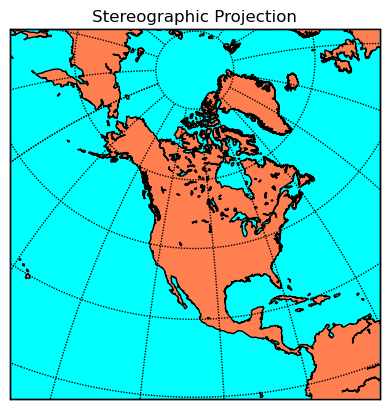

In [4]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup stereographic basemap.
# lat_ts is latitude of true scale.
# lon_0,lat_0 is central point.
m = Basemap(width=12000000, height=12000000,
            resolution='l', projection='stere',\
            lat_ts=50,lat_0=50,lon_0=-107.)


m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='aqua') 
# draw tissot's indicatrix to show distortion.
ax = plt.gca()
#for y in np.linspace(m.ymax/20,19*m.ymax/20,9):
#    for x in np.linspace(m.xmax/20,19*m.xmax/20,12):
#        lon, lat = m(x,y,inverse=True)
#        poly = m.tissot(lon,lat,1.5,100,\
#                        facecolor='green',zorder=10,alpha=0.5)
plt.title("Stereographic Projection")
plt.show()

Implementation below is from [NSIDC GitHub](https://github.com/nsidc/polarstereo-lonlat-convert-py/tree/main/polar_convert)

`constants.py`

In [8]:
# The grid size cell dimensions in km
VALID_GRID_SIZES = (6.25, 12.5, 25)

# Valid hemisphere names.
NORTH = 'north'
SOUTH = 'south'
VALID_HEMISPHERES = (NORTH, SOUTH)

# Earth-parameter defualts
TRUE_SCALE_LATITUDE = 70
EARTH_RADIUS_KM = 6378.273
EARTH_ECCENTRICITY = 0.081816153

`polar_convert.py`

In [ ]:
import numpy as np

from polar_convert.constants import (
    EARTH_ECCENTRICITY,
    EARTH_RADIUS_KM,
    NORTH,
    TRUE_SCALE_LATITUDE,
)
from polar_convert.validators import validate_hemisphere, validate_grid_size


def _hemi_direction(hemisphere):
    """Return `1` for 'north' and `-1` for 'south'"""
    return {'north': 1, 'south': -1}[hemisphere]


def polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere):
    """Convert from Polar Stereographic (x, y) coordinates to
    geodetic longitude and latitude.

    Args:
        x (float): X coordinate(s) in km
        y (float): Y coordinate(s) in km
        true_scale_lat (float): true-scale latitude in degrees
        hemisphere ('north' or 'south'): Northern or Southern hemisphere
        re (float): Earth radius in km
        e (float): Earth eccentricity

    Returns:
        If x and y are scalars then the result is a
        two-element list containing [longitude, latitude].
        If x and y are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.
    """

    hemisphere = validate_hemisphere(hemisphere)
    hemi_direction = _hemi_direction(hemisphere)

    e2 = e * e
    slat = true_scale_lat * np.pi / 180
    rho = np.sqrt(x ** 2 + y ** 2)

    if abs(true_scale_lat - 90.) < 1e-5:
        t = rho * np.sqrt((1 + e) ** (1 + e) * (1 - e) ** (1 - e)) / (2 * re)
    else:
        cm = np.cos(slat) / np.sqrt(1 - e2 * (np.sin(slat) ** 2))
        t = np.tan((np.pi / 4) - (slat / 2)) / \
            ((1 - e * np.sin(slat)) / (1 + e * np.sin(slat))) ** (e / 2)
        t = rho * t / (re * cm)

    chi = (np.pi / 2) - 2 * np.arctan(t)
    lat = chi + \
        ((e2 / 2) + (5 * e2 ** 2 / 24) + (e2 ** 3 / 12)) * np.sin(2 * chi) + \
        ((7 * e2 ** 2 / 48) + (29 * e2 ** 3 / 240)) * np.sin(4 * chi) + \
        (7 * e2 ** 3 / 120) * np.sin(6 * chi)
    lat = hemi_direction * lat * 180 / np.pi
    lon = np.arctan2(hemi_direction * x, -hemi_direction * y)
    lon = hemi_direction * lon * 180 / np.pi
    lon = lon + np.less(lon, 0) * 360
    
    return [lon, lat]


def polar_lonlat_to_xy(longitude, latitude, true_scale_lat, re, e, hemisphere):
    """Convert from geodetic longitude and latitude to Polar Stereographic
    (X, Y) coordinates in km.

    Args:
        longitude (float): longitude or longitude array in degrees
        latitude (float): latitude or latitude array in degrees (positive)
        true_scale_lat (float): true-scale latitude in degrees
        re (float): Earth radius in km
        e (float): Earth eccentricity
        hemisphere ('north' or 'south'): Northern or Southern hemisphere

    Returns:
        If longitude and latitude are scalars then the result is a
        two-element list containing [X, Y] in km.
        If longitude and latitude are numpy arrays then the result will be a
        two-element list where the first element is a numpy array containing
        the X coordinates and the second element is a numpy array containing
        the Y coordinates.
    """

    hemisphere = validate_hemisphere(hemisphere)
    hemi_direction = _hemi_direction(hemisphere)

    lat = abs(latitude) * np.pi / 180
    lon = longitude * np.pi / 180
    slat = true_scale_lat * np.pi / 180

    e2 = e * e

    # Snyder (1987) p. 161 Eqn 15-9
    t = np.tan(np.pi / 4 - lat / 2) / \
        ((1 - e * np.sin(lat)) / (1 + e * np.sin(lat))) ** (e / 2)

    if abs(90 - true_scale_lat) < 1e-5:
        # Snyder (1987) p. 161 Eqn 21-33
        rho = 2 * re * t / np.sqrt((1 + e) ** (1 + e) * (1 - e) ** (1 - e))
    else:
        # Snyder (1987) p. 161 Eqn 21-34
        tc = np.tan(np.pi / 4 - slat / 2) / \
            ((1 - e * np.sin(slat)) / (1 + e * np.sin(slat))) ** (e / 2)
        mc = np.cos(slat) / np.sqrt(1 - e2 * (np.sin(slat) ** 2))
        rho = re * mc * t / tc

    x = rho * hemi_direction * np.sin(hemi_direction * lon)
    y = -rho * hemi_direction * np.cos(hemi_direction * lon)
    return [x, y]


def _grid_params(grid_size, hemisphere):
    if hemisphere == NORTH:
        delta = 45
        imax = 1216
        jmax = 1792
        xmin = -3850 + grid_size / 2
        ymin = -5350 + grid_size / 2
    else:
        delta = 0
        imax = 1264
        jmax = 1328
        xmin = -3950 + grid_size / 2
        ymin = -3950 + grid_size / 2

    if grid_size == 12.5:
        imax = imax // 2
        jmax = jmax // 2
    elif grid_size == 25:
        imax = imax // 4
        jmax = jmax // 4

    return delta, imax, jmax, xmin, ymin


def polar_ij_to_lonlat(i, j, grid_size, hemisphere):
    """Transform from NSIDC Polar Stereographic I, J coordinates
    to longitude and latitude coordinates

    Args:
        i (int): an integer or integer array giving the x grid_size coordinate(s)
        j (int): an integer or integer array giving the y grid_size coordinate(s)
        grid_size (float): 6.25, 12.5 or 25; the grid_size cell dimensions in km
        hemisphere ('north' or 'south'): Northern or Southern hemisphere

    Returns:
        If i and j are scalars then the result is a
        two-element list containing [longitude, latitude].
        If i and j are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.

    Examples:
        print(nsidc_polar_ij(608, 896, 12.5, 1))
            [350.01450147320855, 34.40871032516291]
    """

    validate_grid_size(grid_size)
    hemisphere = validate_hemisphere(hemisphere)

    delta, imax, jmax, xmin, ymin = _grid_params(grid_size, hemisphere)

    if np.any(np.less(i, 1)) or np.any(np.greater(i, imax)):
        raise ValueError("'i' value is out of range: [1, " + str(imax) + "]")
    if np.any(np.less(j, 1)) or np.any(np.greater(j, jmax)):
        raise ValueError("'j' value is out of range: [1, " + str(jmax) + "]")

    # Convert I, J pairs to x and y distances from origin.
    x = ((i - 1) * grid_size) + xmin
    y = ((jmax - j) * grid_size) + ymin
    lon, lat = polar_xy_to_lonlat(
        x,
        y,
        TRUE_SCALE_LATITUDE,
        EARTH_RADIUS_KM,
        EARTH_ECCENTRICITY,
        hemisphere
    )
    lon = lon - delta
    lon = lon + np.less(lon, 0) * 360

    return [lon, lat]


def polar_lonlat_to_ij(longitude, latitude, grid_size, hemisphere):
    """Transform from geodetic longitude and latitude coordinates
    to NSIDC Polar Stereographic I, J coordinates

    Args:
        longitude (float): longitude or longitude array in degrees
        latitude (float): latitude or latitude array in degrees (positive)
        grid_size (float): 6.25, 12.5 or 25; the grid_size cell dimensions in km
        hemisphere ('north' or 'south'): Northern or Southern hemisphere

    Returns:
        If longitude and latitude are scalars then the result is a
        two-element list containing [I, J].
        If longitude and latitude are numpy arrays then the result will
        be a two-element list where the first element is a numpy array for
        the I coordinates and the second element is a numpy array for
        the J coordinates.

    Examples:
        print(nsidc_polar_lonlat(350.0, 34.41, 12.5, 1))
            [608, 896]
    """

    validate_grid_size(grid_size)
    hemisphere = validate_hemisphere(hemisphere)

    delta, imax, jmax, xmin, ymin = _grid_params(grid_size, hemisphere)

    x, y = polar_lonlat_to_xy(
        longitude + delta,
        np.abs(latitude),
        TRUE_SCALE_LATITUDE,
        EARTH_RADIUS_KM,
        EARTH_ECCENTRICITY,
        hemisphere
    )
    i = (np.round((x - xmin) / grid_size)).astype(int) + 1
    j = (np.round((y - ymin) / grid_size)).astype(int) + 1
    # Flip grid_size orientation in the 'y' direction
    j = jmax - j + 1
    return [i, j]

Using `pyproj` library

[**Note**]: See [spatialreference.org](https://spatialreference.org/) for more info about the codes. Specifically the [EPSG:4326](https://spatialreference.org/ref/epsg/4326/).

In [1]:
import pyproj

# Spatial reference system 
p = pyproj.Proj(init='epsg:4326')
print(p)
print(p.srs)
# Coordinate reference system 

# Define some common projections using EPSG codes 
wgs84 = pyproj.CRS("EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth 

proj=longlat datum=WGS84 no_defs ellps=WGS84 towgs84=0,0,0
+proj=longlat +datum=WGS84 +no_defs


/nix/store/nlr3b2kwi955l8cwq485x7vmk9xk6wlx-python3-3.11.9-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [3]:
import pyproj 

source_crs = pyproj.CRS.from_epsg(3995)

print("Name:", source_crs.name)
print("Coordinate system:", source_crs.coordinate_system)
print("Bounds:", source_crs.area_of_use.bounds)
print("Datum:", source_crs.datum)
print()

target_crs = pyproj.CRS.from_epsg(3035)

print("Name:", target_crs.name)
print("Coordinate system:", target_crs.coordinate_system)
print("Bounds:", target_crs.area_of_use.bounds)
print("Datum:", target_crs.datum)
print()

polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)

Name: WGS 84 / Arctic Polar Stereographic
Coordinate system: cartesian
Bounds: (-180.0, 60.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble

Name: ETRS89-extended / LAEA Europe
Coordinate system: cartesian
Bounds: (-35.58, 24.6, 44.83, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble



{'Conventions': 'CF-1.7', 'Title': 'BedMachine Antarctica', 'Author': 'Mathieu Morlighem', 'version': '03-Jun-2022 (v3.4)', 'nx': 13333.0, 'ny': 13333.0, 'Projection': 'Polar Stereographic South (71S,0E)', 'proj4': '+init=epsg:3031', 'sea_water_density (kg m-3)': 1027.0, 'ice_density (kg m-3)': 917.0, 'xmin': -3333000, 'ymax': 3333000, 'spacing': 500, 'no_data': -9999.0, 'license': 'No restrictions on access or use', 'Data_citation': 'Morlighem M. et al., (2019), Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet, Nature Geoscience (accepted)', 'Notes': 'Data processed at the Department of Earth System Science, University of California, Irvine'} 

proj=pipeline step inv proj=stere lat_0=-90 lat_ts=-71 lon_0=0 x_0=0 y_0=0 ellps=WGS84 step proj=unitconvert xy_in=rad xy_out=deg step proj=axisswap order=2,1


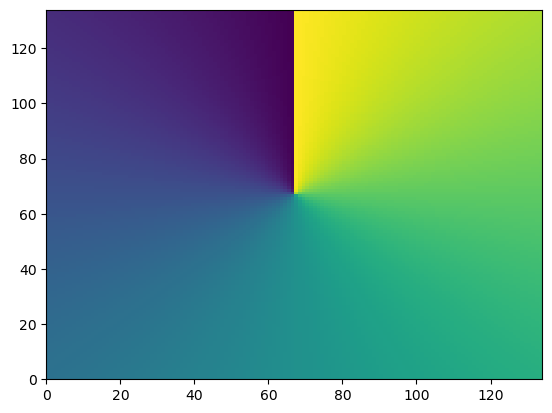

In [1]:
import xarray 
import pyproj 
import numpy as np 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 

myfile = "./BedMachineAntarctica-v3.nc"
mydata = xarray.open_dataset(myfile)
subset = mydata.isel(x=slice(None, None, 100), y=slice(None, None, 100))
#subset.surface.plot()

print(subset.attrs, "\n")

# Converting between CRS 
source_crs = 'epsg:3031' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system

polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
#print(polar_to_latlon)
#lat, lon = polar_to_latlon.transform(subset.x, subset.y)
#plt.plot(lon, lat)

#ax = plt.axes(projection=ccrs.SouthPolarStereo())
#ax.plot(lon, lat, transform=ccrs.PlateCarree())
#ax.coastlines()

X, Y = np.meshgrid(subset.x, subset.y)
lat, lon = polar_to_latlon.transform(X, Y)

plt.pcolormesh(lon)

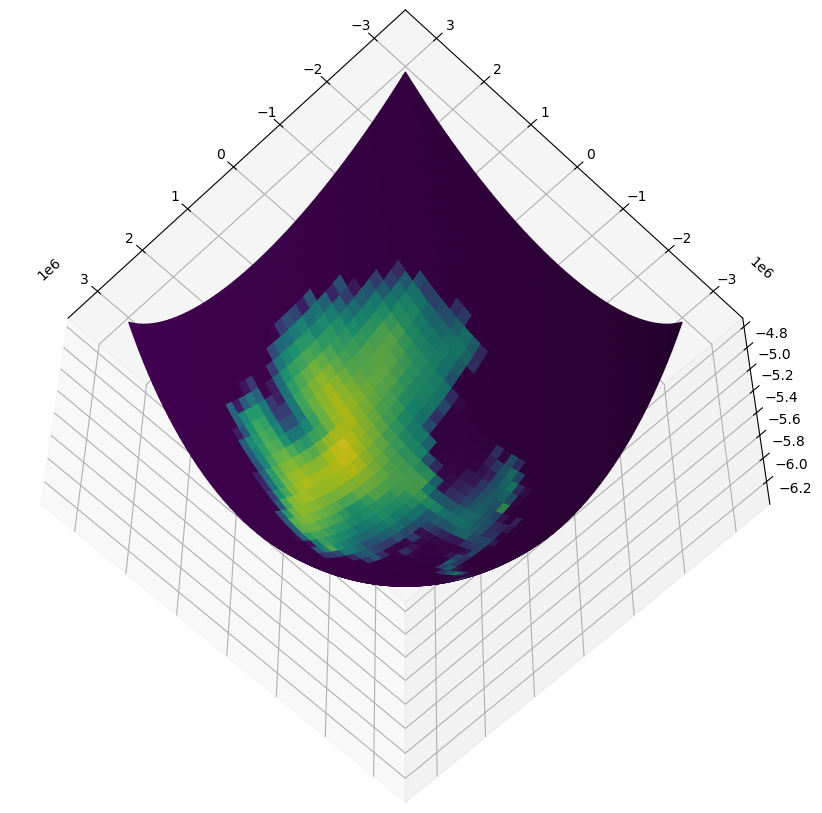

In [29]:
polar_to_cart = pyproj.Transformer.from_crs(source_crs, '+proj=geocent')
cX, cY, cZ = polar_to_cart.transform(X, Y, 0*X)

import matplotlib

plt.figure(figsize=(15,10))

# Make a 3d plot
ax = plt.axes(projection='3d')

# Use the values to colour the surface
cmap = plt.cm.ScalarMappable(cmap='viridis')
colors = cmap.to_rgba(subset.surface)

ax.plot_surface(cX, cY, cZ, facecolors=colors)

# Camera position
ax.elev = -60
ax.azim = 135

## 

In [17]:
# Standard library modules 
import os, sys
import pickle
import pathlib as pb 

# Third-party modules 
#from numpy import full, nan, array
import numpy as np

# ---- Testing ----
import matplotlib
tkagg = matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
#import simplekml


# Getting custom modules
# Add the root of your project to PYTHONPATH
rootpath = pb.Path('.').resolve().parents[1]
syspath = str(rootpath.joinpath("src", "cimr-grasp"))
sys.path.append(syspath) 
syspath = str(rootpath.joinpath("src"))
sys.path.append(syspath)
#print(syspath)
import grasp_io as gio
from config_file import ConfigFile
from grid_generator import GridGenerator, GRIDS
from data_ingestion import DataIngestion
from regridder_v2 import ReGridder


# TODO: Write method similar to lotlan_to_xy but which will work for Universal polar Steriographic projection 

# genarate grid from a given grid definition 

# convert long lats into xy 

if __name__ == '__main__':

    # Initiate config object and validate parameters.
    configpath = rootpath.joinpath('config-maks.xml')
    config = ConfigFile(configpath)#os.path.join(os.getcwd(), '..', 'config.xml'))

    print(configpath.resolve())
    
    # You can already run GridGenerator with the config object. You can generate
    # an x, y grid and then convert those coordinates to lon, lat. The type of
    # grid that will be generated will of course depend on what you have put in the
    # config file. I would try this first using an EASE grid. For example, put in the config
    # gridDefinition='EASE_G36' and projectionDefinition = 'G'.

    x_grid, y_grid = GridGenerator(config).generate_grid_xy() 

    #print(x_grid, y_grid)

    # Convert the grid to lon, lat
    lon_grid, lat_grid = GridGenerator(config).xy_to_lonlat(x_grid, y_grid)

    # [Maksym]

    # Now you can play around with some SMAP data. The l1b data is given in lon, lat (epsg:4326)
    # and you may want to convert to x, y. First run data_ingestion to get the data dict
    #data_dict = DataIngestion(config).ingest_data()

    # Convert coordinates to x, y
    # Depending on whether you have split_fore_aft = True or False, you will have to change the name
    # of the input lon, lat.
    #lon_sample = data_dict['L']['longitude_fore']
    #lat_sample = data_dict['L']['latitude_fore']
    # print(lon_sample[:100])
    #x_sample, y_sample = GridGenerator(config).lonlat_to_xy(lon_sample, lat_sample)

    # For the functions xy_to_lonlat and lonlat_to_xy, you can also just use a random single data
    # point to validate its working correctly for example:
    #x_test = 0
    #y_test = 0
    #lon_test, lat_test = GridGenerator(config).xy_to_lonlat(x_test, y_test)

    #print(data_dict['L'].keys())

    # Now if you want to regrid the data to the grid you have generated, you can call the regridder
    # function. Note: the regridder function calls the grid generator within it. I would start with
    # NN.

    #data_dict_out = ReGridder(config).regrid_l1c(data_dict)

    # Data_dict out is the same format as data_dict, with the added variables cell_row, cell_col
    # which provide the location of each data point in the ease array. I think it is highly likely
    # that this won't work straight away with the new grid, but we can deal with it when you get there.

    # Here you can save any of the variables you want to inspect.
    #save_path = '/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/output/proj_test'
    #with open(os.path.join(save_path, 'data_dict_out.pkl'), 'wb') as f:
    #    pickle.dump(data_dict_out, f)

    # The following code plots the regridded data onto an EASE grid.
    # Get shape from GRIDS dictionary
    #grid_shape = GRIDS[config.grid_definition]['n_rows'], GRIDS[config.grid_definition]['n_cols']
    # Create nan array with shape of grid_shape
    #grid = np.full(grid_shape, np.nan)
    # Extract the variable you want plot
    #variable = data_dict_out['L']['bt_h_fore']
    # Extract the locations on the grid
    #cell_row = data_dict_out['L']['cell_row_fore']
    #cell_col = data_dict_out['L']['cell_col_fore']
    # Put the data in the grid
    #for i in range(len(cell_row)):
    #    grid[cell_row[i], cell_col[i]] = variable[i]
    # Plot Grid
    #plt.imshow(grid)
    #plt.show() 

/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/config-maks.xml
dict_keys(['bt_h_fore', 'bt_h_aft', 'sub_satellite_lon_fore', 'sub_satellite_lon_aft', 'longitude_fore', 'longitude_aft', 'y_velocity_fore', 'y_velocity_aft', 'bt_v_fore', 'bt_v_aft', 'y_position_fore', 'y_position_aft', 'sub_satellite_lat_fore', 'sub_satellite_lat_aft', 'x_velocity_fore', 'x_velocity_aft', 'z_velocity_fore', 'z_velocity_aft', 'latitude_fore', 'latitude_aft', 'z_position_fore', 'z_position_aft', 'processing_scan_angle_fore', 'processing_scan_angle_aft', 'x_position_fore', 'x_position_aft', 'scan_number_fore', 'scan_number_aft', 'sample_number_fore', 'sample_number_aft', 'feed_horn_number_fore', 'feed_horn_number_aft'])
fore
bt_h_fore
bt_v_fore
aft
bt_h_aft
bt_v_aft


In [3]:
import sys 
import pathlib as pb 
import json 

import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import pyproj as pj 

# Getting custom modules
# Add the root of your project to PYTHONPATH
rootpath = pb.Path('.').resolve().parents[1]
syspath = str(rootpath.joinpath("src", "cimr-grasp"))
sys.path.append(syspath) 
syspath = str(rootpath.joinpath("src"))
sys.path.append(syspath)
#print(syspath)
import grasp_io as gio
from config_file import ConfigFile
from grid_generator import GridGenerator, GRIDS
from data_ingestion import DataIngestion
from regridder_v2 import ReGridder

# I DEFINE GRID MYSELF BASED OFF THE BOUNDS PROVIDED FROM PYPROJ (FROM SPECIFIC EPSG CODE)

# "Spilhaus World Ocean in a Square" Map projection Parameters in ArcGIS software: 
# https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d
# 
# Geographic Coordinate System: GCS WGS 1984
# Projection: Adams Square II
# False Easting: 0 m
# False Northing: 0 m
# Scale Factor: 1
# Azimuth: 40.17823482°
# Longitude of Center: 66.94970198°E
# Latitude of Center: 49.56371678°S
# XY Plane Rotation: 45°
# 
# A very nice paper that gives an overview of all possible Spilhaus Projections: 
# https://blog.map-projections.net/spilhaus-projections-a-quintet-of-world-ocean-maps 
# 
# The general discussion on GitHub: 
# https://github.com/OSGeo/PROJ/issues/1851 
# From user @kerkovits: 
# 
# I did some calculations and it seems that ellipsoidal formulae are a bit more complicated than I originally assumed but still possible to implement:
# 
# Step 1: calculate conformal latitude of of the center. Use formula (3-1) of https://pubs.usgs.gov/pp/1395/report.pdf substitute the latitude of center for phi, and the first eccentricity to e. I will call the result chi as the conformal_latitude_of_center. This step should be omitted for spherical calculations.
# 
# Step 2: calculate the following quantities:
# alpha=asin(cos(conformal_latitude_of_center)*cos(azimuth)) (should be a bit less than +30° for ellipsoidal formulae and exactly +30° for a sphere)
# lambda_0=longitude_of_center+atan2(tan(azimuth),-sin(conformal_latitude_of_center)) (should be exactly +115°)
# beta=atan2(-sin(azimuth),-tan(conformal_latitude_of_center)) (should be approximately -29°)
# 
# Step 3: Calculate the conformal latitude of the mapped point by formula (3-1). Skip this step for spherical formula.
# 
# Step 4: Calculate phi_prime and lambda_prime from formulae (5-7) and (5-8b). Use constants alpha, beta, and lambda_0 from step 2 and use the conformal latitude from step 3 for phi. Lambda is the longitude of the mapped point.
# 
# Step 5: Apply the spherical Adams projection for phi_prime and lambda_prime.
# 
# Step 6: Rotate the result by 45° clockwise.
# 
# Step 7: Rejoice.
# 
# P.S. You should use atan2 for the arctan in formula (5-8b) at step 4.
# 
# https://github.com/riatelab/bertin/blob/main/src/projections/spilhaus.js
# 
# Python implementation: 
# https://github.com/rtlemos/spilhaus/blob/main/spilhaus.py

if __name__ == '__main__': 

    # Initiate config object and validate parameters.
    configpath = rootpath.joinpath('config-maks.xml')
    config = ConfigFile(configpath)#os.path.join(os.getcwd(), '..', 'config.xml'))
    # Now you can play around with some SMAP data. The l1b data is given in lon, lat (epsg:4326)
    # and you may want to convert to x, y. First run data_ingestion to get the data dict
    data_dict = DataIngestion(config).ingest_data()

    print(data_dict['L'].keys())

    lon  = data_dict['L']['longitude_fore'][20000:30000]
    lat  = data_dict['L']['latitude_fore'][20000:30000]
    data = data_dict['L']['bt_h_fore'][20000:30000]

    # DO NOT USE THIS ONE BECAUSE YOU WILL RUN OUT OF MEMORY 
    #lat_grid, lon_grid = np.meshgrid(lat, lon)

    #print(lon_sample.shape) 
    #print(lat_sample.shape)

    # See conversion between geographic and projection coordinates within one datum: 
    # https://pyproj4.github.io/pyproj/stable/examples.html#converting-between-geographic-and-projection-coordinates-within-one-datum 
    # Initialising Coordinate Reference System 
    # Codes are available here: 
    # https://spatialreference.org/ 
    # 
    # EPSG:4326 -- WGS 84 (Entire World). Axes: Geodetic latitude, Geodetic longitude (Lat,Lon)
    # EPSG:3413 -- WGS 84 / NSIDC Sea Ice Polar Stereographic North. Axes: Easting, Northing (X,Y). Base CRS: EPSG:4326
    # EPSG:3976 -- WGS 84 / NSIDC Sea Ice Polar Stereographic South. Axes: Easting, Northing (X,Y). Base CRS: EPSG:4326
    # 
    # NSIDC about Polar Stereographic: 
    # https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection
    source_crs = pj.CRS.from_epsg(4326)
    target_crs = pj.CRS.from_epsg(3413)

    # Creating Transformer to perfomr grid transformations 
    # https://pyproj4.github.io/pyproj/stable/api/transformer.html#pyproj.transformer.Transformer.from_crs
    transformer = pj.Transformer.from_crs(crs_from = source_crs, crs_to = target_crs)

    # There is also an iterator for transformation 
    # https://pyproj4.github.io/pyproj/stable/api/transformer.html#pyproj.transformer.Transformer.itransform
    #X, Y = np.meshgrid(subset.x, subset.y)
    #x, y = transformer.transform(lat_grid, lon_grid)
    x, y = transformer.transform(lat, lon) 

    print(x.shape)
    print(y.shape)

    print(x)
    

    # Perform regridding to L1c using Nearest Neighbour
    # (interpolation basically)
    data_interp = sp.interpolate.RegularGridInterpolator((x, y), data)
    
    #print(crs_wgs84.geodetic_crs)

    #print(crs_wgs84)

    #print("Name:", crs_wgs84.name)
    #print("Coordinate system:", crs_wgs84.coordinate_system)
    #print("Area of Use:", crs_wgs84.area_of_use)
    #print("Bounds:", crs_wgs84.area_of_use.bounds)
    #print("Datum:", crs_wgs84.datum)
    #print("Ellipsoid", crs_wgs84.ellipsoid)
    #print("Authority:", crs_wgs84.list_authority)

    #print() 

    #print(crs_wgs84.to_dict())
    #print() 
    # Convert CRS object to a JSON dict (to be able to output it into better format)
    #crs_wgs84_dict = crs_wgs84.to_json_dict()
    #latlon_to_polar = pyproj.Transformer.from_crs(target_crs, crs_wgs84)
    
    # Print the JSON dict in a pretty format
    #print(json.dumps(crs_wgs84_dict, indent=4))

    
    
    # Create a generate grid 

    # Convert grid to lat long 

    #myfile = "./BedMachineAntarctica-v3.nc"
    #mydata = xarray.open_dataset(myfile)
    #subset = mydata.isel(x=slice(None, None, 100), y=slice(None, None, 100))
    
    # Converting between CRS 
    #source_crs = 'epsg:3031' # Coordinate system of the file
    #target_crs = 'epsg:4326' # Global lat-lon coordinate system
    
    #polar_to_latlon = pj.Transformer.from_crs(source_crs, target_crs)
    #print(polar_to_latlon)
    #lat, lon = polar_to_latlon.transform(subset.x, subset.y)
    #plt.plot(lon, lat)
    
    #ax = plt.axes(projection=ccrs.SouthPolarStereo())
    #ax.plot(lon, lat, transform=ccrs.PlateCarree())
    #ax.coastlines()
    
    #X, Y = np.meshgrid(subset.x, subset.y)
    #lat, lon = polar_to_latlon.transform(X, Y)

dict_keys(['y_velocity_fore', 'y_velocity_aft', 'sub_satellite_lat_fore', 'sub_satellite_lat_aft', 'latitude_fore', 'latitude_aft', 'longitude_fore', 'longitude_aft', 'z_velocity_fore', 'z_velocity_aft', 'x_position_fore', 'x_position_aft', 'bt_h_fore', 'bt_h_aft', 'z_position_fore', 'z_position_aft', 'bt_v_fore', 'bt_v_aft', 'processing_scan_angle_fore', 'processing_scan_angle_aft', 'x_velocity_fore', 'x_velocity_aft', 'sub_satellite_lon_fore', 'sub_satellite_lon_aft', 'y_position_fore', 'y_position_aft', 'scan_number_fore', 'scan_number_aft', 'sample_number_fore', 'sample_number_aft', 'feed_horn_number_fore', 'feed_horn_number_aft'])
(10000,)
(10000,)
[-591963.68092117 -601471.53249745 -610685.59982286 ...  -27674.16112528
  -31832.26984814  -35563.65833886]


ValueError: The points in dimension 0 must be strictly ascending or descending

In [6]:
# Define the CRS for EPSG:3409
crs_3409 = pj.CRS.from_epsg(3976)#3409)

# Print out the CRS information
print(crs_3409)

# Alternatively, you can access specific information
# For example, get the projection parameters
print("\nProjection Type:", crs_3409.coordinate_system)
print("Axis Info:", crs_3409.axis_info)
print("Bounds (if available):", crs_3409.area_of_use.bounds)

# Access full details of the projection
print("\nFull details:\n", crs_3409.to_proj4())

EPSG:3976

Projection Type: cartesian
Axis Info: [Axis(name=Easting, abbrev=X, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre), Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]
Bounds (if available): (-180.0, -90.0, 180.0, -60.0)

Full details:
 +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs


## __*Mercator*__

### Forward Formulas 


### Reverse Formulas 


## __*Spilhaus*__

See this [github post on implementing Spilhaus](https://github.com/OSGeo/PROJ/issues/1851#issuecomment-773149503)

Java implementation [the same github thread](https://github.com/OSGeo/PROJ/issues/1851#issuecomment-889966275): 
```
private final static double
        α = Math.toRadians(30), sinα = sin(α), cosα = cos(α),
        β = Math.toRadians(-28.8013495219182);

public ProjCoordinate changePole(double λ, double ϕ, ProjCoordinate out) {
    final double 
            cosϕ = cos(-ϕ), sinϕ = sin(-ϕ),
            cosλ = cos(-λ), sinλ = sin(-λ),
            sin_ϕp = sinα*sinϕ - cosα*cosϕ*cosλ, //  5-7
            ϕp = asin(sin_ϕp),
            λp = atan2(cosϕ*sinλ, sinα*cosϕ*cosλ + cosα*sinϕ) + β; // 5-8b
    out.x = -ProjectionMath.normalizeLongitude(λp);
    out.y = -ϕp;
    return out;
}

@Override
public ProjCoordinate project(double lplam, double lpphi, ProjCoordinate xy) {
    // Conformal latitude
    double x = 2.*atan(tan(Math.PI/4. + lpphi/2)*pow((1 - e*sin(lpphi))/(1 + e*sin(lpphi)),e/2))- Math.PI/2.; // 3-1
    final ProjCoordinate rotLamPhi = changePole(lplam, x, new ProjCoordinate());
    lplam = rotLamPhi.x;
    lpphi = rotLamPhi.y;
	final double 
            spp = tan(.5 * lpphi),
            sa = cos(aasin(spp)) * sin(.5 * lplam),
            b = aacos(spp),
            a = aacos(cos(aasin(spp)) * sin(.5 * lplam));
    xy.x = ell_int_5(((spp + sa) < 0. ? -1 : 1) * aasin(sqrt(   (1. + min(0., cos(a + b))))));
    xy.y = ell_int_5(((spp - sa) < 0. ? -1 : 1) * aasin(sqrt(abs(1. - max(0., cos(a - b))))));
    return xy;
}
```

The complete [Java implementation](https://github.com/OSGeo/PROJ/issues/1851#issuecomment-943138537) is: 
```
/*
Copyright 2021 Sebastien Durand based on (2006 Jerry Huxtable)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
*/

package org.osgeo.proj4j.proj;

import static java.lang.Math.abs;
import static java.lang.Math.asin;
import static java.lang.Math.atan2;
import static java.lang.Math.cos;
import static java.lang.Math.max;
import static java.lang.Math.min;
import static java.lang.Math.sin;
import static java.lang.Math.sqrt;
import static java.lang.Math.tan;
import org.osgeo.proj4j.ProjCoordinate;
import org.osgeo.proj4j.parser.Proj4Keyword;
import org.osgeo.proj4j.util.ProjectionMath;
import static org.osgeo.proj4j.util.ProjectionMath.aacos;
import static org.osgeo.proj4j.util.ProjectionMath.aasin;

public class SpilhausProjection extends Projection {

protected final static double TOL = 1e-9;
protected final static double RSQRT2 = 0.7071067811865475244008443620;
protected final static double M_2_PI = 0.63661977236758134308;
protected final static double SEC_TO_RAD = Math.PI/(3600.*180.); 
  
private final static double C[] = {
    -8.58691003636495e-07,
    2.02692115653689e-07,
    3.12960480765314e-05,
    5.30394739921063e-05,
    -0.0012804644680613,
    -0.00575574836830288,
    0.0914203033408211,};

private static double ell_int_5(double phi) {
    /* Procedure to compute elliptic integral of the first kind
     * where k^2=0.5.  Precision good to better than 1e-7
     * The approximation is performed with an even Chebyshev
     * series, thus the coefficients below are the even values
     * and where series evaluation  must be multiplied by the argument. */
    double C0 = 2.19174570831038;
    double y = phi * M_2_PI;
    y = 2. * y * y - 1.;
    double y2 = 2. * y, d1 = 0., d2 = 0.0;
    for (double c : C) {
        double temp = d1;
        d1 = y2 * d1 - d2 + c;
        d2 = temp;
    }
    return phi * (y * d1 - d2 + 0.5 * C0);
}

public SpilhausProjection() {
    initialize();
}

/**
 * Applying these relationships to transformations, without showing some inter�mediate derivations, 
 * formulas (5-7) through (5-8b) are obtained. 
 * To place the North Pole of the sphere at a latitude α on a meridian β east of the central meridian (λp = 0) 
 * of the basic projection (see fig. 6), the transformed latitude ϕp and transformed longitude λp 
 * on the basic projection which correspond to latitude ϕ and longitude λ of the spherical Earth may be calculated as follows, 
 * letting the central meridian λ0 correspond with λp = β
*/


// Formulas ref from (Map projections - a working Manual) by John P.Snyder
// Thanks to kerkovits comments on https://github.com/OSGeo/PROJ/issues/1851
protected final static double
        α = Math.toRadians(30), sinα = sin(α), cosα = cos(α),
        β = Math.toRadians(-28.8013495219182);

public ProjCoordinate changePole(double λ, double ϕ, ProjCoordinate out) {
    final double 
            λ0 = 0,
            cosϕ = cos(ϕ), sinϕ = sin(ϕ),
            cosλ_λ0 = cos(λ-λ0), sinλ_λ0 = sin(λ-λ0),
            sinϕp = sinα*sinϕ - cosα*cosϕ*cosλ_λ0, //  5-7
            ϕp = asin(sinϕp),
            λp = atan2(cosϕ*sinλ_λ0, sinα*cosϕ*cosλ_λ0 + cosα*sinϕ) + β; // 5-8b
    out.x = ProjectionMath.normalizeLongitude(λp);
    out.y = ϕp;
    return out;
}

public ProjCoordinate changePoleInv(double λp, double ϕp, ProjCoordinate out) {
    final double
            λ0 = 0,
            cosλp_β = cos(λp-β),
            cosϕp = cos(ϕp), sinϕp = sin(ϕp),
            ϕ = asin(sinα*sinϕp + cosα*cosϕp*cosλp_β),                        // 5-9
            λ = atan2(cosϕp*sin(λp-β),(sinα*cosϕp*cosλp_β-cosα*sinϕp)) + λ0;  // 5-10b
    out.x = ProjectionMath.normalizeLongitude(λ);  
    out.y = ϕ;
    return out;
}

public static ProjCoordinate changePoleFull(double λ, double ϕ, double α, double β, double λ0, ProjCoordinate out) {
    final double 
            cosϕ = cos(ϕ), sinϕ = sin(ϕ),
            cosλ = cos(λ-λ0), sinλ = sin(λ-λ0),
            sin_ϕp = sin(α)*sinϕ - cos(α)*cosϕ*cosλ, //  5-7
            ϕp = asin(sin_ϕp),
            λp = atan2(cosϕ*sinλ, sin(α)*cosϕ*cosλ + cos(α)*sinϕ) + β; // 5-8b
    out.x = ProjectionMath.normalizeLongitude(λp);
    out.y = -ϕp;
    return out;
}


@Override
public ProjCoordinate project(double lplam, double lpphi, ProjCoordinate xy) {
    // Conformal latitude
    double x = lpphi - SEC_TO_RAD*(700.0427 * sin(2 * lpphi) + 0.9900 * sin(4 * lpphi) + 0.0017 * sin(6 * lpphi));  // 3-3
    // Change pole
    final ProjCoordinate rotLamPhi = changePole(-lplam, -x, new ProjCoordinate());
    // Admas Square 2 Projection
    return projectAdamsSq2(-rotLamPhi.x, -rotLamPhi.y, xy);
}        

public static ProjCoordinate projectAdamsSq2(double lplam, double lpphi, ProjCoordinate xy) {
    final double 
            spp = tan(.5 * lpphi),
            sa = cos(aasin(spp)) * sin(.5 * lplam),
            b = aacos(spp),
            a = aacos(cos(aasin(spp)) * sin(.5 * lplam));
    xy.x = ell_int_5(((spp + sa) < 0. ? -1 : 1) * aasin(sqrt(   (1. + min(0., cos(a + b))))));
    xy.y = ell_int_5(((spp - sa) < 0. ? -1 : 1) * aasin(sqrt(abs(1. - max(0., cos(a - b))))));
    return xy;
}

@Override
public ProjCoordinate projectInverse(double xyx, double xyy, ProjCoordinate out) {
    // Inverse Adams square II projection
    out.y = max(min(xyy / 2.62181347, 1.0), -1.0) * M_HALFPI;
    out.x = abs(out.y) >= M_HALFPI ? 0 : max(min(xyx / 2.62205760 / cos(out.y), 1.0), -1.0) * M_PI;
    ProjCoordinate out2 = pj_generic_inverse_2d_AdamsSq2(xyx, xyy, out);
    // Inverse change Pole
    changePoleInv(-out2.x, -out2.y, out);
    // Inverse Conformal 
    double x = -out.y;
    out.y = x + SEC_TO_RAD*(700.0420* sin(2*x) + 1.3859 *sin(4*x) + 0.0037 * sin(6*x));   // 3-6
    out.x = -out.x;
    return out;
}

@Override
public void initialize() {
    super.initialize();
    this.es = 0;
    this.projectionLongitude = Math.toRadians(115);
}

/**
 * Returns true if this projection is equal area
 */
@Override
public boolean isEqualArea() {
    return true;
}

@Override
public boolean hasInverse() {
    return true;
}

/**
 * Returns the ESPG code for this projection, or 0 if unknown.
 *
 * @return
 */
@Override
public int getEPSGCode() {
    return 54099;
}

@Override
public String toString() {
    return "Spilhaus";
}

@Override
public Proj4Keyword[] getLstRequiredParams() {
    return new Proj4Keyword[]{};
}

@Override
public Proj4Keyword[] getLstOptinalParams() {
    return new Proj4Keyword[]{};
}

public ProjCoordinate pj_generic_inverse_2d_AdamsSq2(double xyx, double xyy, ProjCoordinate lpInitial) {
    ProjCoordinate lp = new ProjCoordinate(lpInitial.x, lpInitial.y);
    double deriv_lam_X = 0;
    double deriv_lam_Y = 0;
    double deriv_phi_X = 0;
    double deriv_phi_Y = 0;

    for (int i = 0; i < 15; i++) {
        ProjCoordinate xyApprox = projectAdamsSq2(lp.x, lp.y, new ProjCoordinate());
        
        double deltaX = xyApprox.x - xyx;
        double deltaY = xyApprox.y - xyy;
        if (abs(deltaX) < 1e-10 && abs(deltaY) < 1e-10) {
            return lp;
        }

        if (i == 0 || abs(deltaX) > 1e-6 || abs(deltaY) > 1e-6) {
            // Compute Jacobian matrix (only if we aren't close to the final
            // result to speed things a bit)
            ProjCoordinate lp2 = new ProjCoordinate();
            ProjCoordinate xy2 = new ProjCoordinate();
            double dLam = lp.x > 0 ? -1e-6 : 1e-6;
            lp2.x = lp.x + dLam;
            lp2.y = lp.y;
            xy2 = projectAdamsSq2(lp2.x,lp2.y, xy2);
            double deriv_X_lam = (xy2.x - xyApprox.x) / dLam;
            double deriv_Y_lam = (xy2.y - xyApprox.y) / dLam;

            double dPhi = lp.y > 0 ? -1e-6 : 1e-6;
            lp2.x = lp.x;
            lp2.y = lp.y + dPhi;
            xy2 = projectAdamsSq2(lp2.x,lp2.y, xy2);
            double deriv_X_phi = (xy2.x - xyApprox.x) / dPhi;
            double deriv_Y_phi = (xy2.y - xyApprox.y) / dPhi;

            // Inverse of Jacobian matrix
            double det = deriv_X_lam * deriv_Y_phi - deriv_X_phi * deriv_Y_lam;
            if (det != 0) {
                deriv_lam_X = deriv_Y_phi / det;
                deriv_lam_Y = -deriv_X_phi / det;
                deriv_phi_X = -deriv_Y_lam / det;
                deriv_phi_Y = deriv_X_lam / det;
            }
        }

        if (xyx != 0) {
            // Limit the amplitude of correction to avoid overshoots due to
            // bad initial guess
            double delta_lam = max( min(deltaX * deriv_lam_X + deltaY * deriv_lam_Y, 0.3), -0.3);
            lp.x -= delta_lam;
            if (lp.x < -M_PI)
                lp.x = -M_PI;
            else if (lp.x > M_PI)
                lp.x = M_PI;
        }

        if (xyy != 0) {
            double delta_phi = max( min(deltaX * deriv_phi_X + deltaY * deriv_phi_Y, 0.3), -0.3);
            lp.y -= delta_phi;
            if (lp.y < -M_HALFPI)
                lp.y = -M_HALFPI;
            else if (lp.y > M_HALFPI)
                lp.y = M_HALFPI;
        }
    }
  //  proj_context_errno_set(P->ctx, PROJ_ERR_COORD_TRANSFM_OUTSIDE_PROJECTION_DOMAIN);
    return lp;
 }
}
```

In [ ]:
import numpy as np 

In [ ]:
import pyproj
import matplotlib.pyplot as plt

# Define a PyProj transformer for North Pole Stereographic (EPSG:3413)
north_pole_proj = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)

# Define a PyProj transformer for South Pole Stereographic (EPSG:3031)
south_pole_proj = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)

def project_polar(latitudes, longitudes, projection='north'):
    """
    Function to project geographic coordinates (lat, lon) to stereographic projection.
    
    Parameters:
    latitudes: list or np.array of latitudes
    longitudes: list or np.array of longitudes
    projection: 'north' for North Pole, 'south' for South Pole
    
    Returns:
    x, y: Projected Cartesian coordinates
    """
    if projection == 'north':
        x, y = north_pole_proj.transform(longitudes, latitudes)
    elif projection == 'south':
        x, y = south_pole_proj.transform(longitudes, latitudes)
    else:
        raise ValueError("Projection type must be 'north' or 'south'")
    
    return x, y

# Example usage
if __name__ == "__main__":
    # Sample latitude and longitude points
    latitudes = [90, 85, 80, 75, 70]  # Near the North Pole
    longitudes = [0, 45, 90, 135, 180]
    
    # Project the points using the polar stereographic projection (North Pole)
    x, y = project_polar(latitudes, longitudes, projection='north')
    
    # Plot the projection
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c='red', label='Projected Points (North Pole)')
    for i in range(len(latitudes)):
        plt.text(x[i], y[i], f'({latitudes[i]}°, {longitudes[i]}°)', fontsize=9)
    
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.title('Polar Stereographic Projection (North Pole)')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()


In [ ]:
import pyproj
import xarray as xr
import matplotlib.pyplot as plt

# Load satellite data (NetCDF format example)
# Replace with your actual file path and variable names
nc_file = '/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/dpr/L1B/SMAP/SMAP_L1B_TB_47172_D_20231201T000114_R18290_001.h5'
satellite_data = xr.open_dataset(nc_file)




# Assuming the NetCDF data contains latitude and longitude variables
latitudes = satellite_data['lat'].values  # Replace 'lat' with the actual variable name in your dataset
longitudes = satellite_data['lon'].values  # Replace 'lon' with the actual variable name

# Let's assume the data we're interested in is temperature (for example)
data_variable = satellite_data['temperature'].values  # Replace 'temperature' with the actual variable

# Set up PyProj transformer for North Pole Stereographic Projection (EPSG:3413)
north_pole_proj = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)

# Perform the projection
x, y = north_pole_proj.transform(longitudes, latitudes)



# Plot the data using Matplotlib
plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, data_variable, cmap='coolwarm')  # Plot temperature data, you can replace the colormap
plt.colorbar(label='Temperature (K)')  # Add a colorbar with label
plt.title('Polar Stereographic Projection - Satellite Data')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid(True)
plt.show()


In [ ]:
import h5py
import pyproj
import numpy as np
import matplotlib.pyplot as plt

# Open the HDF5 file
h5_file = '/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/dpr/L1B/SMAP/SMAP_L1B_TB_47172_D_20231201T000114_R18290_001.h5'

with h5py.File(h5_file, 'r') as f:
    # Explore the structure of the HDF5 file
    print(f.keys())
    print(f['Brightness_Temperature'].keys())  # Check the available datasets in the file
    
    # Assuming the dataset contains latitude, longitude, and some variable data
    latitudes     = f['Brightness_Temperature']['tb_lat'][:]  # Replace 'lat' with the actual dataset name in your HDF5 file
    longitudes    = f['Brightness_Temperature']['tb_lon'][:]  # Replace 'lon' with the actual dataset name in your HDF5 file
    data_variable = f['Brightness_Temperature']['tb_h'][:]  # Replace 'data' with the actual dataset name for your variable

# Create a PyProj transformer for North Pole Stereographic (EPSG:3413)
north_pole_proj = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)

# Project the latitude and longitude to x, y coordinates (Polar Stereographic)
x, y = north_pole_proj.transform(longitudes, latitudes)

print(x, y)

# Plot the data using Matplotlib
plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, data_variable, cmap='viridis')  # Use pcolormesh to plot the projected data
plt.colorbar(label='Variable')  # Add colorbar with a label for the variable
plt.title('Polar Stereographic Projection - Satellite Data')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid(True)
plt.show()
